# Polymer Properties Model Refinement
Data and methodology taken from: Estimation and Prediction of the Polymers’ Physical Characteristics Using the Machine Learning Models Polymers 2024, 16(1), 115; https://doi.org/10.3390/polym16010115.

Github repository: https://github.com/catauggie/polymersML/tree/main

The goal of this notebook is to recreate the methods outlined in the above publication to begin the refine the model of linear regression using different ML techniques.  Each technique is described along with its pro's and cons and a short evaluation of the methods is given based on their theoretical applicability i.e. without taking into consideration the actual performance of these methods on the dataset.

In [1]:
# Go ahead and import the data into a dataframe and then make sure its imported properly by listing the first few lines
import pandas as pd
new_df = pd.read_excel('Tg_Data_Frame.xlsx')
new_df.head(3)

,Unnamed: 0,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,...,col_1015,col_1016,col_1017,col_1018,col_1019,col_1020,col_1021,col_1022,col_1023,Glass transition temperature_value_median
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-60.00
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.39
2,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-24.05


# Tuning the model

## Function Definitions
Below we define some functions and plots which were not avaliable in the original publication however they give us insights into the performance of each of the algorithms and provide simple visual comparison. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



def evaluate_model_performance(y_test, y_pred):
    """
    Evaluate the performance of a model using various metrics.
    
    Parameters:
    - y_test: array-like of shape (n_samples,) or (n_samples, n_outputs), 
              True values for X.
    - y_pred: array-like of shape (n_samples,) or (n_samples, n_outputs),
              Estimated target values.
    """
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    variance_score = explained_variance_score(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)

    print(f'Mean Squared Error: {mse:.3f}')
    print(f'R-squared: {r2:.3f}')
    print(f'Mean Absolute Error: {mae:.3f}')
    print(f'Explained Variance Score: {variance_score:.3f}')
    print(f'Median Absolute Error: {medae:.3f}')

# Example usage:
# y_test = [actual values]
# y_pred = [predicted values]
# evaluate_model_performance(y_test, y_pred)


def plot_actual_vs_predicted(y_test, y_pred):
    """
    Plot the actual vs. predicted values to evaluate a model's performance.
    
    Parameters:
    - y_test: array-like, True values.
    - y_pred: array-like, Predicted values.
    """
    plt.figure(figsize=(10, 6))  # Set the figure size for better readability

    # Scatter plot for actual vs. predicted values
    plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs. Actual')

    # Ideal line for perfect predictions
    max_val = max(max(y_test), max(y_pred))  # Find the maximum value for setting plot limits
    min_val = min(min(y_test), min(y_pred))  # Find the minimum value for setting plot limits
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal Fit')

    # Customization and labels
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Model Predictions vs. Actual Data')
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()

# Example usage:
# y_test = [actual values]
# y_pred = [predicted values]
# plot_actual_vs_predicted(y_test, y_pred)

def bland_altman_plot(y_test, y_pred):
    """
    Generate a Bland-Altman plot to assess the agreement between two sets of measurements.
    
    Parameters:
    - y_test: array-like, true values.
    - y_pred: array-like, predicted values.
    """
    avg = (y_test + y_pred) / 2
    diff = y_test - y_pred

    plt.figure(figsize=(10, 6))
    plt.scatter(avg, diff, alpha=0.5)
    plt.axhline(y=np.mean(diff), color='r', linestyle='--', label='Mean Difference')
    plt.axhline(y=np.mean(diff) + 1.96 * np.std(diff), color='g', linestyle='--', label='Upper Limit of Agreement')
    plt.axhline(y=np.mean(diff) - 1.96 * np.std(diff), color='g', linestyle='--', label='Lower Limit of Agreement')
    plt.xlabel('Average of Actual and Predicted Values')
    plt.ylabel('Difference Between Actual and Predicted Values')
    plt.title('Bland-Altman Plot')
    plt.legend()
    plt.show()

# Example usage:
# y_test = [actual values]
# y_pred = [predicted values]
# bland_altman_plot(y_test, y_pred)


## Random Forest Regressor

The RandomForestRegressor is a popular machine learning algorithm that belongs to the ensemble learning family, specifically within the Random Forests methodology. It operates by constructing a multitude of decision trees at training time and outputting the mean or average prediction of the individual trees. This method is particularly used for regression tasks, where the goal is to predict a continuous outcome variable. 

Below, I'll outline the pros and cons of using a RandomForestRegressor, its applications, and its potential use in predicting glass transition temperatures from molecular fingerprints.

### Pros of RandomForestRegressor
* **Accuracy**: RandomForestRegressor is known for providing high accuracy in many prediction tasks due to its ensemble approach, which reduces overfitting by averaging the results of numerous trees.
* **Robustness**: It can handle outliers and nonlinear data effectively, making it robust across various datasets.
* **Feature Importance**: It inherently provides insights into feature importance, which can be valuable for understanding the factors influencing the prediction.
* **Versatility**: Can be used for both regression and classification tasks, making it applicable to a wide range of problems.
* **Handling Missing Values**: Capable of handling missing values in the dataset without requiring extensive pre-processing.
* **Parallelizable**: The algorithm can be easily parallelized across multiple CPUs for faster processing, which is beneficial for dealing with large datasets.

### Cons of RandomForestRegressor
* **Complexity**: It creates numerous trees (which can be computationally intensive) and requires more memory and processing power, especially as the number of trees increases.
* **Interpretability**: While individual decision trees are interpretable, the ensemble nature of RandomForest makes it more challenging to interpret the model's predictions directly.
* **Long Training Time**: For large datasets or a large number of trees, the training time can be significantly longer compared to simpler models.
* **Overfitting with Noisy Data**: Despite its robustness to overfitting, in cases of extremely noisy data, the model can still overfit.

### Applications
RandomForestRegressor is widely applicable in various domains, including:

* **Financial Market Analysis**: For predicting stock prices, market trends, and risk assessment.
* **Healthcare**: In predicting disease outbreak, patient prognosis, and treatment effectiveness.
* **Environmental Modeling**: For forecasting weather patterns, air quality, and climate change effects.
* **Real Estate**: In estimating property values based on numerous features.
Retail: For demand forecasting and inventory management.

### Predicting Glass Transition Temperatures
RandomForestRegressor can be particularly suited for this task due to its ability to handle complex, non-linear relationships between features (in this case, molecular fingerprints) and the target variable (glass transition temperatures). The model can capture the intricate patterns and dependencies in the molecular structure that influence the glass transition temperature.

The molecular fingerprints, which represent the presence or absence of certain molecular structures and properties, serve as input features for the RandomForestRegressor. By training on these features along with known glass transition temperatures, the model can learn the relationship between the molecular structure and the transition temperature, thereby enabling it to predict the glass transition temperatures of new compounds.

This application leverages the RandomForestRegressor's strengths in handling complex, high-dimensional data and its robustness to variations in the data, making it a promising approach for predicting properties of materials based on their molecular composition. However, success in this specific application would also depend on the quality and representativeness of the training data, the selection of relevant features from the molecular fingerprints, and the tuning of the model's hyperparameters to optimize performance.


Mean Squared Error: 2115.649
R-squared: 0.828
Mean Absolute Error: 32.259
Explained Variance Score: 0.828
Median Absolute Error: 23.070


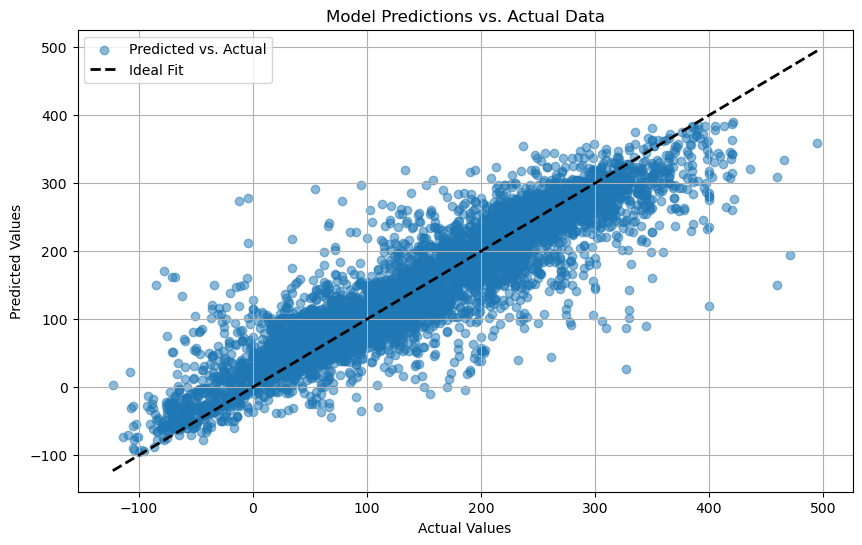

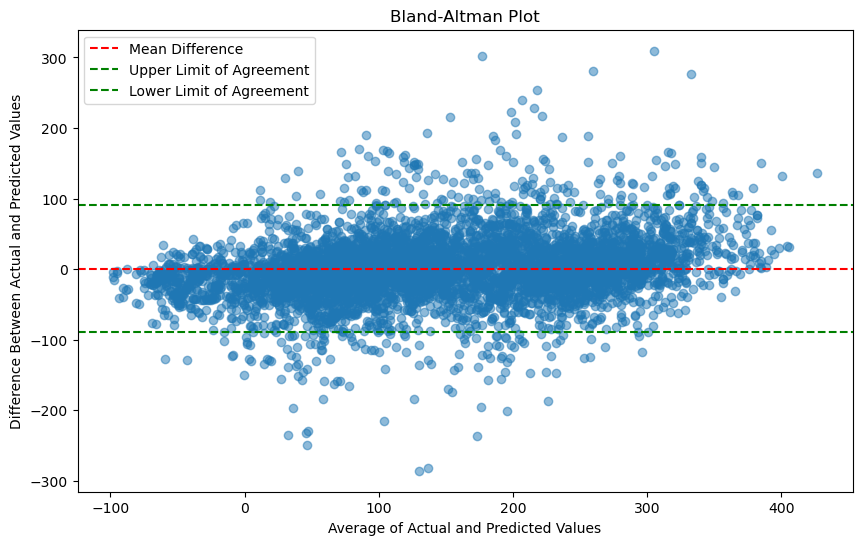

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'df' is your DataFrame
# Assuming 'df' is your DataFrame
cols = [c for c in new_df.columns if 'col' in c]
X = new_df[cols]
y = new_df['Glass transition temperature_value_median']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

# Initialize the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=1000, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

evaluate_model_performance(y_test, y_pred)
plot_actual_vs_predicted(y_test, y_pred)
bland_altman_plot(y_test, y_pred)

## Gradient Boosting Regressor
Another powerful machine learning algorithm that uses the boosting strategy to improve prediction accuracy. It builds an ensemble of weak prediction models, typically decision trees, in a sequential manner where each tree tries to correct the errors made by the previous ones. This approach focuses on converting weak learners into strong ones over iterations, optimizing a loss function. Below are the pros and cons of using GradientBoostingRegressor, its applications, and its potential use in predicting glass transition temperatures from molecular fingerprints.

## Pros of GradientBoostingRegressor
* **High Accuracy*: Gradient boosting is capable of producing highly accurate models by systematically addressing errors of previous models through optimization.
* **Flexibility**: It can handle various types of data (numerical, categorical) and is adaptable to different loss functions, making it suitable for a wide range of regression and classification tasks.
* **Handling Non-linear Data**: Due to its sequential approach in correcting errors, it can model complex non-linear relationships effectively.
* **Feature Importance**: Similar to RandomForest, gradient boosting provides insights into which features are most important for making predictions.
* **Overfitting Control**: Offers several hyperparameters (like the number of trees, depth of trees, learning rate) that can be fine-tuned to prevent overfitting.

## Cons of GradientBoostingRegressor
* **Training Time**: The sequential nature of boosting means it can be slower to train compared to models that allow parallelization, such as random forests.
* **Complexity and Tuning**: Requires careful tuning of hyperparameters to achieve the best performance without overfitting. This process can be time-consuming and complex.
* **Memory Usage**: Can consume more memory than simpler models, especially as the number of trees and depth increases.
* **Risk of Overfitting**: If not properly tuned, especially with too many trees or too deep trees, it can overfit the training data.


## Applications
Gradient Boosting Regressor finds its application in diverse fields, including but not limited to:

* **Finance*: For credit scoring, risk management, and algorithmic trading strategies.
* **Healthcare**: In disease prediction, personalized medicine, and healthcare resource optimization.
* **Energy**: Forecasting electricity demand, renewable energy output predictions, and price forecasting.
* **Retail and E-commerce**: For customer lifetime value prediction, sales forecasting, and inventory management.
* **Real Estate**: Predicting house prices based on various features like location, size, and amenities.

## Predicting Glass Transition Temperatures
The prediction of glass transition temperatures from molecular fingerprints is a nuanced task that can benefit from the high accuracy and flexibility of the Gradient Boosting Regressor. This method is particularly useful for capturing the complex, non-linear relationships between the molecular structure (encoded as fingerprints) and their physical properties, such as the glass transition temperature.

Molecular fingerprints, which encode the presence of particular molecular features, serve as the input to the model. The Gradient Boosting Regressor can iteratively learn from the subtle nuances in how these features correlate with the glass transition temperatures. By focusing on minimizing the prediction error in each step, it can effectively predict the glass transition temperatures for new, unseen molecules.

This application benefits from the model's ability to handle complex datasets and its robustness against overfitting (when properly tuned), making it a potent tool in the field of materials science and chemistry. The success of GradientBoostingRegressor in predicting glass transition temperatures will largely depend on the quality of the molecular fingerprint data, the representativeness of the training dataset, and the optimization of model parameters to the specific characteristics of the data.

Mean Squared Error: 2912.646
R-squared: 0.763
Mean Absolute Error: 40.301
Explained Variance Score: 0.763
Median Absolute Error: 31.259


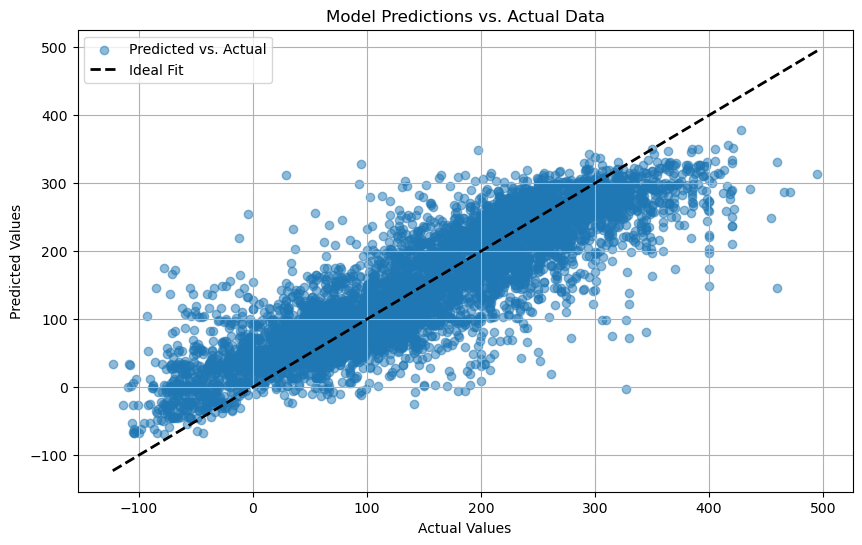

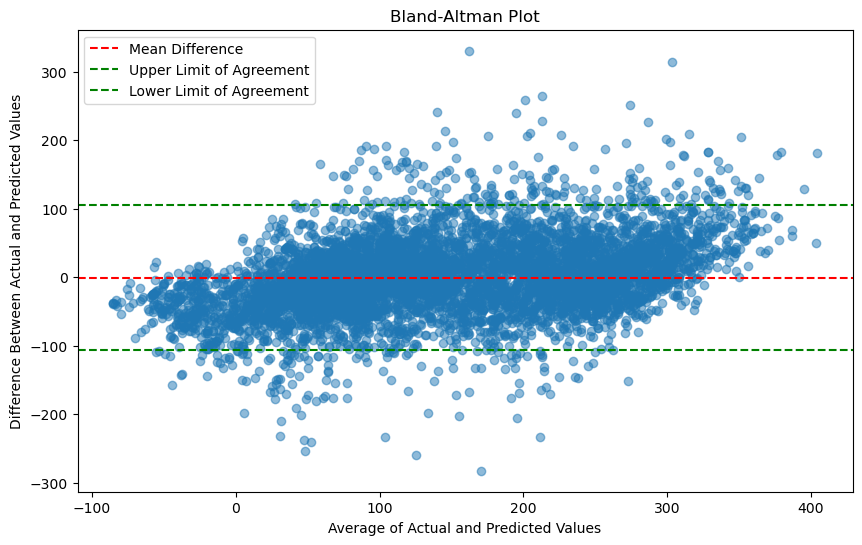

In [4]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'df' is your DataFrame
cols = [c for c in new_df.columns if 'col' in c]
X = new_df[cols]
y = new_df['Glass transition temperature_value_median']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Initialize the Gradient Boosting Regressor model
model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

evaluate_model_performance(y_test, y_pred)
plot_actual_vs_predicted(y_test, y_pred)
bland_altman_plot(y_test, y_pred)

## Support Vector Regressor

Support Vector Regressor (SVR) is a type of Support Vector Machine (SVM) that is used for regression problems. It operates on the principle of finding the best fit line (in two dimensions) or hyperplane (in more than two dimensions) that has the maximum number of points within a certain distance from it. The SVR uses kernel functions to transform the original data into a higher-dimensional space where it is easier to perform the linear separation. Below are the pros and cons of using SVR, its applications, and its potential use in predicting glass transition temperatures from molecular fingerprints.

**Pros of SupportVectorRegressor (SVR)**
* **Effectiveness in High-Dimensional Spaces**: SVR performs well in cases where the number of dimensions exceeds the number of samples, which is beneficial for complex datasets.
* **Versatility**: Through the use of different kernel functions (linear, polynomial, RBF, sigmoid), SVR can adapt to various types of data distributions, making it versatile for different regression tasks.
* **Robustness**: SVR is less prone to overfitting, especially in high-dimensional space, due to its regularization parameters that control the balance between achieving a low error on the training data and minimizing the norm of the coefficients.
* **Sparse Solution**: Only a subset of the training data (the support vectors) is used in the decision function constructed by SVR, making the model potentially more efficient and easier to interpret.

**Cons of SupportVectorRegressor (SVR)**
* **Scaling and Normalization**: SVR requires careful data preprocessing, such as feature scaling and normalization, to perform well. This can be time-consuming and may require domain knowledge.
* **Computational Complexity**: Training SVR can be computationally intensive, especially for large datasets, because it involves solving a quadratic optimization problem.
* **Parameter Selection**: Choosing the right kernel function and tuning the hyperparameters (C, epsilon, and kernel parameters) can be challenging and requires a grid search or similar optimization techniques, which increases the computational burden.
* **Limited Interpretability**: Understanding how the chosen kernel function and hyperparameters affect the final model can be difficult, making SVR models less interpretable than simpler models.

**Applications**
SupportVectorRegressor has been successfully applied in various domains, including but not limited to:

* **Finance**: For predicting stock prices, currency exchange rates, and financial risk management.
* **Healthcare**: In drug response modeling, patient risk assessment, and progression of diseases.
* **Energy**: Forecasting electricity consumption, solar radiation levels, and wind power generation.
* **Environmental Science**: For predicting pollution levels, temperature changes, and other climatic factors.
* **Real Estate**: Estimating property values based on location, size, and other features.

**Predicting Glass Transition Temperatures**
Predicting glass transition temperatures from molecular fingerprints is a sophisticated task that could leverage the capabilities of SVR, especially given its effectiveness in high-dimensional spaces and its versatility with different kernel functions. Molecular fingerprints, which effectively capture the essence of molecular structures in a high-dimensional space, can be challenging to relate directly to physical properties like glass transition temperatures due to the complex, non-linear relationships involved.

SVR, with its ability to project data into higher-dimensional spaces using kernel functions, can uncover these complex relationships between the molecular fingerprints and the glass transition temperatures. By optimizing the SVR model's parameters, one can develop a predictive model that is both accurate and robust against overfitting, despite the potentially high dimensionality and complexity of the data.

For this application, the choice of kernel function and the tuning of SVR's hyperparameters (like C for regularization, epsilon for the margin of tolerance, and kernel-specific parameters) are critical for achieving good performance. The model's success will heavily depend on these choices, along with the quality and representativeness of the training data. Thus, while SVR offers a promising approach for predicting glass transition temperatures from molecular fingerprints, its effectiveness will be closely tied to careful model development and validation practices.

Mean Squared Error: 2248.091
R-squared: 0.821
Mean Absolute Error: 33.960
Explained Variance Score: 0.821
Median Absolute Error: 23.947


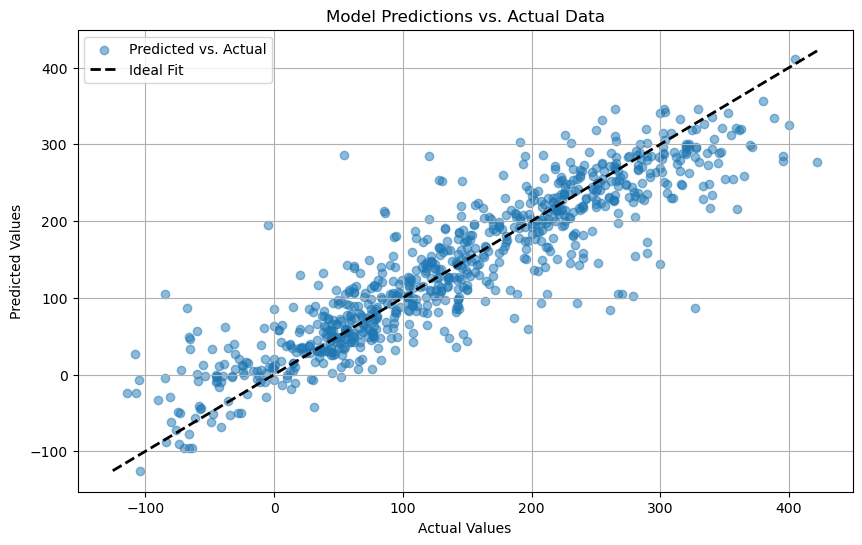

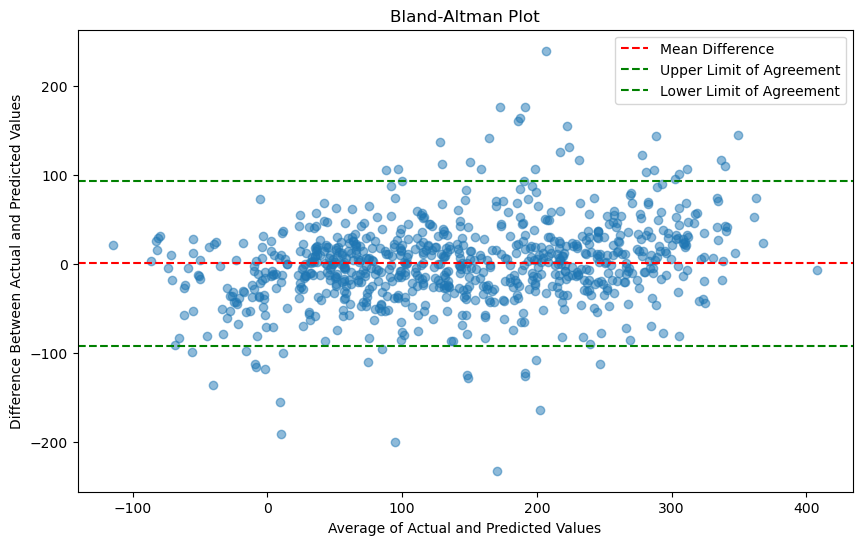

In [5]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


cols = [c for c in new_df.columns if 'col' in c]
X = new_df[cols]
y = new_df['Glass transition temperature_value_median']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize the Support Vector Regressor model
model = SVR(kernel='linear')  # You can experiment with different kernels: 'linear', 'poly', 'rbf', etc.

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

evaluate_model_performance(y_test, y_pred)
plot_actual_vs_predicted(y_test, y_pred)
bland_altman_plot(y_test, y_pred)

## Lasso Regression
The Lasso Regressor (Least Absolute Shrinkage and Selection Operator) is a type of linear regression that includes a regularization term. The regularization term is the absolute value of the magnitude of coefficients, which encourages the sum of the absolute values of the regression coefficients to be small and can lead to some coefficients being exactly zero. This property of Lasso regression not only helps in reducing overfitting but also performs feature selection automatically, making it a useful tool for models with high dimensionality or when we want to identify important features. Below, I will outline the pros and cons of using Lasso Regressor, its applications, and its potential use in predicting glass transition temperatures from molecular fingerprints.

**Pros of Lasso Regressor**
* **Feature Selection**: One of the key advantages of Lasso is its ability to perform feature selection automatically by shrinking less important feature's coefficients to zero, thus helping in identifying the most significant features.
* **Reduction of Complexity**: By eliminating non-important features, Lasso helps in reducing the model's complexity, which can improve model interpretability and reduce overfitting.
* **Efficiency in High-dimensional Spaces**: Lasso can be particularly effective when dealing with high-dimensional data, where the number of features exceeds the number of observations.
* **Predictive Performance**: In scenarios where a small subset of features is expected to have a strong influence on the target variable, Lasso can improve the predictive performance by focusing on those features.

**Cons of Lasso Regressor**
* **Selection of Lambda**: The performance of Lasso regression heavily depends on the choice of the regularization parameter (lambda). Selecting an optimal lambda requires cross-validation, which can be computationally expensive.
* **Bias**: For high values of lambda, Lasso can introduce a significant bias into the model, especially if the true relationship between the features and the target variable is complex.
* **Limitation on Feature Selection**: Lasso might not perform well in situations where there are highly correlated features, as it tends to select one feature from a group of correlated features and ignore the others.
* **Performance in Low-dimensional Space**: In cases where the number of observations significantly exceeds the number of features, Lasso might not provide substantial benefits over Ridge regression or plain linear regression.

**Applications**
Lasso regression is widely used in various fields, such as:

* **Bioinformatics**: For gene selection and the prediction of disease outcomes.
* **Finance**: In credit scoring and portfolio optimization.
* **Marketing**: For identifying significant predictors in consumer behavior and sales forecasting.
* **Environmental Science**: In climate modeling and predicting pollution levels.

**Predicting Glass Transition Temperatures**
Predicting glass transition temperatures from molecular fingerprints is a complex problem that could benefit from Lasso regression's feature selection capability. Given the high-dimensional nature of molecular fingerprints, where each fingerprint represents the presence or absence of certain molecular fragments or features, Lasso can identify the most relevant features that influence the glass transition temperature. This is particularly useful in materials science, where understanding which molecular features most significantly affect material properties can lead to better material design and optimization.

By applying Lasso regression, one could potentially simplify the model by focusing only on the molecular features that have a strong predictive power for glass transition temperatures, thereby improving model interpretability and potentially enhancing predictive accuracy. However, the success of this approach would depend on the correct selection of the regularization parameter and the representativeness of the dataset. Careful cross-validation and domain knowledge are essential to optimize the Lasso model for this specific application, ensuring that it captures the underlying physics of glass transition phenomena accurately.

Mean Squared Error: 2397.567
R-squared: 0.809
Mean Absolute Error: 36.328
Explained Variance Score: 0.809
Median Absolute Error: 27.374


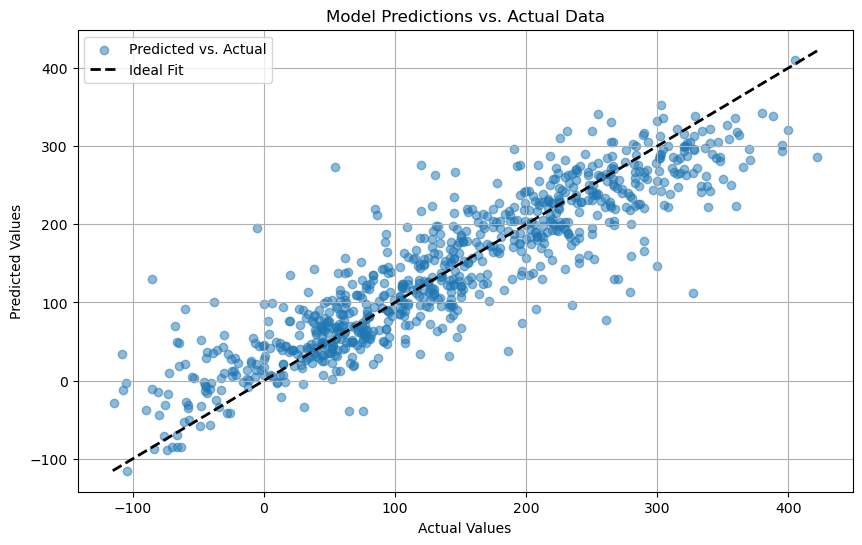

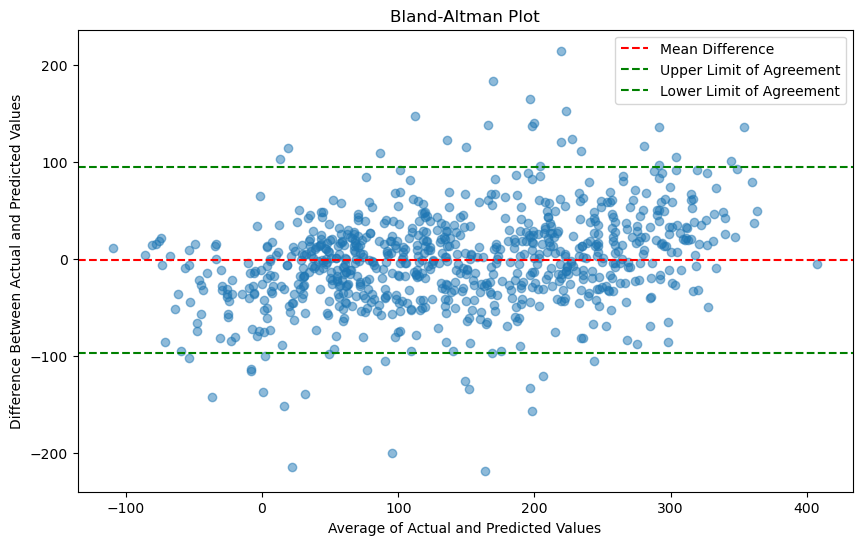

In [6]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Assuming 'df' is your DataFrame
# X should be your features, and y should be your target variable
cols = [c for c in new_df.columns if 'col' in c]
X = new_df[cols]
y = new_df['Glass transition temperature_value_median']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize the Lasso Regression model
model = Lasso(alpha=0.1)  # 'alpha' is the regularization strength, you can adjust it based on your data

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

evaluate_model_performance(y_test, y_pred)
plot_actual_vs_predicted(y_test, y_pred)
bland_altman_plot(y_test, y_pred)

## Elastic Net

Elastic Net regression is a linear regression model that combines the penalties of the Ridge regression (L2 penalty) and Lasso regression (L1 penalty). It aims to benefit from both regularization techniques to handle various types of data, including those with multicollinearity and high dimensionality. Elastic Net adjusts its model complexity by balancing between adding penalties to the size of the coefficients (Ridge) and completely eliminating coefficients (Lasso), making it a versatile tool for regression tasks. Below are the pros and cons of using Elastic Net regression, its applications, and its potential use in predicting glass transition temperatures from molecular fingerprints.

### Pros of Elastic Net Regression

1. **Combines Lasso and Ridge**: Elastic Net includes both L1 and L2 regularization, allowing it to shrink less important feature coefficients to zero (like Lasso) and to handle multicollinearity (like Ridge), making it effective in high-dimensional spaces.

2. **Feature Selection**: Similar to Lasso, Elastic Net can perform feature selection by eliminating non-important features, which simplifies the model and improves interpretability.

3. **Robustness to Multicollinearity**: Elastic Net is more robust to multicollinearity compared to Lasso due to the inclusion of the L2 penalty, which helps in distributing the coefficient values among correlated features more evenly.

4. **Flexibility**: By adjusting the mixing parameter between L1 and L2 penalties, Elastic Net can be tuned to perform optimally across a wide range of datasets and problem types.

### Cons of Elastic Net Regression

1. **Parameter Tuning**: Elastic Net requires tuning of two parameters (alpha for the strength of the regularization and the ratio between L1 and L2 penalties), which can make the model selection process more complex and computationally intensive.

2. **Potentially High Bias**: For high values of regularization strength, Elastic Net can introduce a significant bias into the model, potentially underfitting the data.

3. **Computational Complexity**: The need to optimize over two parameters increases the computational complexity, especially for grid search or cross-validation methods used in hyperparameter tuning.

4. **Performance in Low-dimensional Data**: In cases with fewer features or when the dataset is not high-dimensional, the advantages of Elastic Net might not be as pronounced compared to simpler models.

### Applications

Elastic Net regression is widely applicable across various domains, including:

- **Genomics**: For identifying significant genes related to specific diseases or traits, where the data is high-dimensional with many correlated features.
- **Finance**: In credit scoring models and risk assessment, where it's crucial to select a subset of predictive features from a large pool.
- **Marketing Analytics**: For customer segmentation and predicting customer behavior, where multicollinearity among variables is common.
- **Environmental Modeling**: In climate studies and pollution prediction, to handle datasets with many potentially correlated environmental predictors.

### Predicting Glass Transition Temperatures from Molecular Fingerprints

The prediction of glass transition temperatures from molecular fingerprints is a complex problem that could benefit significantly from Elastic Net regression. Molecular fingerprints are high-dimensional, sparse representations of molecular structures, making them suitable for Elastic Net's capability to perform feature selection and handle multicollinearity.

Elastic Net can be particularly useful in this context for several reasons:

- **Dimensionality Reduction**: By selecting the most relevant features (molecular fragments or structural features) that influence the glass transition temperature, Elastic Net can help in reducing the complexity of the model, making it more interpretable and potentially more accurate.
- **Handling Correlated Features**: In molecular fingerprints, certain features might be correlated (e.g., the presence of similar functional groups), and Elastic Net can manage these correlations more effectively than Lasso alone, by balancing between feature elimination and coefficient shrinkage.
- **Model Optimization**: The flexibility to adjust the balance between L1 and L2 penalties allows for fine-tuning the model to achieve optimal performance on the specific task of predicting glass transition temperatures, which might involve a complex relationship between molecular structure and thermal properties.

By carefully tuning the parameters of Elastic Net and using a representative dataset of molecular structures with known glass transition temperatures, it is possible to develop a predictive model that can aid in the design of new materials with desired thermal properties. This approach can streamline the materials design process, making it faster and more cost-effective by reducing the need for extensive experimental testing.

Mean Squared Error: 2816.281
R-squared: 0.775
Mean Absolute Error: 39.750
Explained Variance Score: 0.775
Median Absolute Error: 29.956


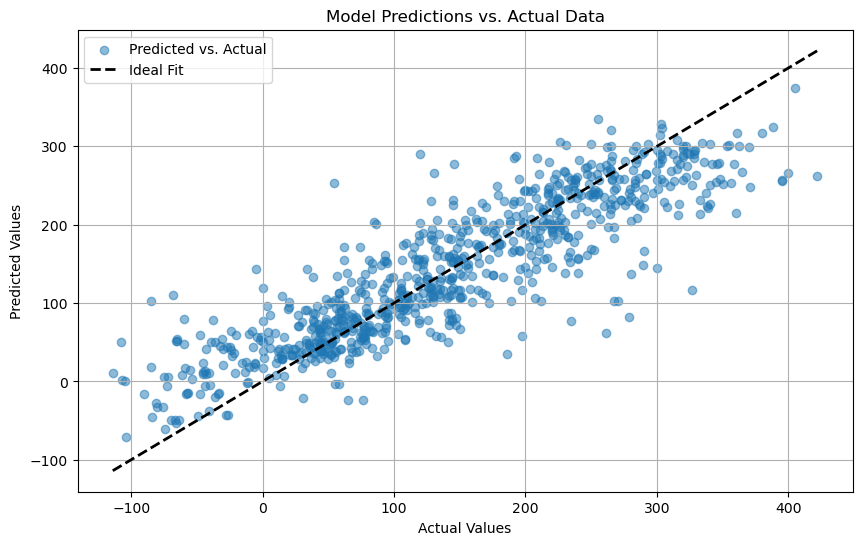

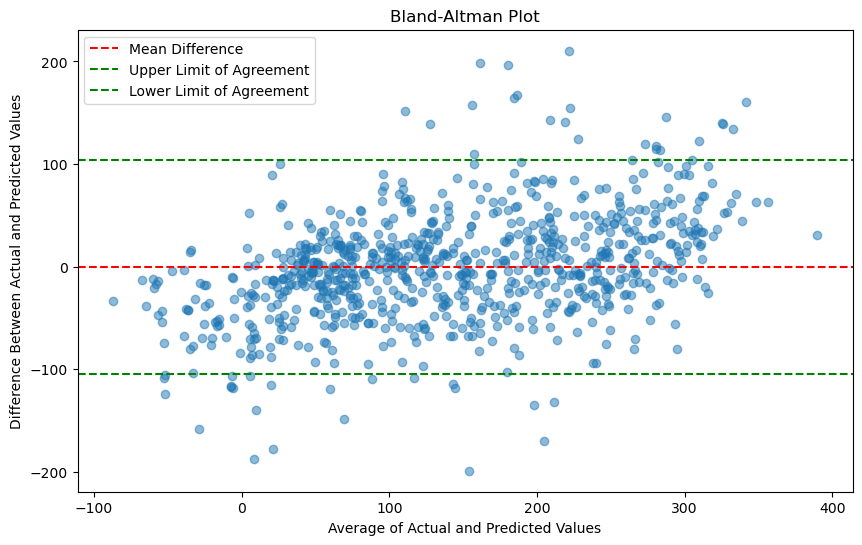

In [7]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'df' is your DataFrame
# X should be your features, and y should be your target variable
cols = [c for c in new_df.columns if 'col' in c]
X = new_df[cols]
y = new_df['Glass transition temperature_value_median']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize the Elastic Net model
model = ElasticNet(alpha=0.1, l1_ratio=0.5)
# 'alpha' is the regularization strength, and 'l1_ratio' controls the mix between L1 and L2 regularization.
# You can adjust these parameters based on your data.

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

evaluate_model_performance(y_test, y_pred)
plot_actual_vs_predicted(y_test, y_pred)
bland_altman_plot(y_test, y_pred)


## K Neighbors Regressor

The KNeighborsRegressor is a type of instance-based learning or non-generalizing learning: it does not attempt to construct a general internal model but simply stores instances of the training data. Prediction is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the value based on how closely it resembles the points in the training set. This method is part of the family of lazy learners, where the function is only approximated locally and all computation is deferred until function evaluation. Below are the pros and cons of using KNeighborsRegressor, its applications, and its potential use in predicting glass transition temperatures from molecular fingerprints.

### Pros of KNeighborsRegressor

1. **Simplicity**: KNN is very simple and easy to implement. The algorithm is straightforward: find the nearest neighbors, then vote on their labels to predict the output.

2. **Versatility**: It can be used for both classification and regression tasks. For regression, the output is the average of the values of its k nearest neighbors.

3. **No Model Assumptions**: Unlike parametric methods, KNN does not make any assumptions about the underlying data distribution, which is useful in cases where the true distribution is not known.

4. **Adaptability**: KNN can adapt to new data, making it suitable for applications where the data is continuously evolving.

### Cons of KNeighborsRegressor

1. **Scalability**: KNN can be computationally expensive, especially with large datasets, as it needs to compute the distance between each query instance and all training samples to identify the nearest neighbors.

2. **Curse of Dimensionality**: Its performance degrades with the increase in dimensionality of the data (high-dimensional feature spaces), due to the distance between points becoming less meaningful.

3. **Sensitive to Irrelevant Features**: KNN can be sensitive to irrelevant or redundant features because all features contribute equally to the similarity measure (distance).

4. **Requirement for Feature Scaling**: Differences in the scale of data dimensions can lead to one dimension dominating the distance measure, so feature scaling (normalization or standardization) is necessary before applying KNN.

### Applications

KNeighborsRegressor has been successfully applied in various domains, such as:

- **Real Estate**: Predicting housing prices based on the features of nearby houses.
- **Recommendation Systems**: Recommending similar items or content based on user preferences and behaviors.
- **Healthcare**: Predicting patient outcomes based on the similarity of their conditions to past patients.

### Predicting Glass Transition Temperatures from Molecular Fingerprints

The application of KNeighborsRegressor for predicting glass transition temperatures from molecular fingerprints could be challenging yet insightful. Molecular fingerprints represent molecules in a high-dimensional space, where each dimension corresponds to the presence or absence of certain molecular features.

- **Dimensionality and Feature Scaling**: Due to the high dimensionality of molecular fingerprints, KNeighborsRegressor might face difficulties due to the curse of dimensionality. Moreover, although molecular fingerprints are binary and thus uniformly scaled, the algorithm's sensitivity to irrelevant features necessitates careful feature selection or dimensionality reduction techniques such as PCA (Principal Component Analysis) before applying KNN.

- **Interpretability of Results**: While KNN can predict glass transition temperatures by finding similar molecules (in terms of molecular fingerprints), interpreting why certain molecules are considered similar and how this similarity relates to glass transition temperatures might require additional analysis.

- **Potential Usefulness**: Despite its limitations, KNN could be a useful exploratory tool for identifying molecules with similar thermal properties and for generating hypotheses about molecular structures that influence glass transition temperatures. This could be particularly valuable in the early stages of research or when complemented with other modeling approaches.

In summary, while KNeighborsRegressor offers an intuitive approach to regression problems, its application to predicting glass transition temperatures from molecular fingerprints might require careful consideration of its limitations, particularly regarding high-dimensional data. Combining KNN with feature selection or dimensionality reduction techniques, and possibly integrating it within a broader ensemble of models, could leverage its strengths while mitigating its weaknesses.

Mean Squared Error: 1797.703
R-squared: 0.856
Mean Absolute Error: 28.874
Explained Variance Score: 0.857
Median Absolute Error: 18.425


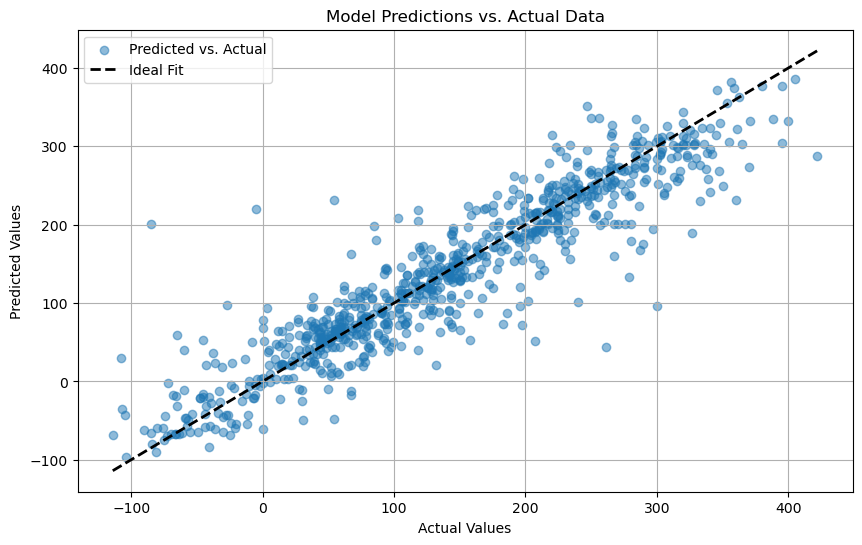

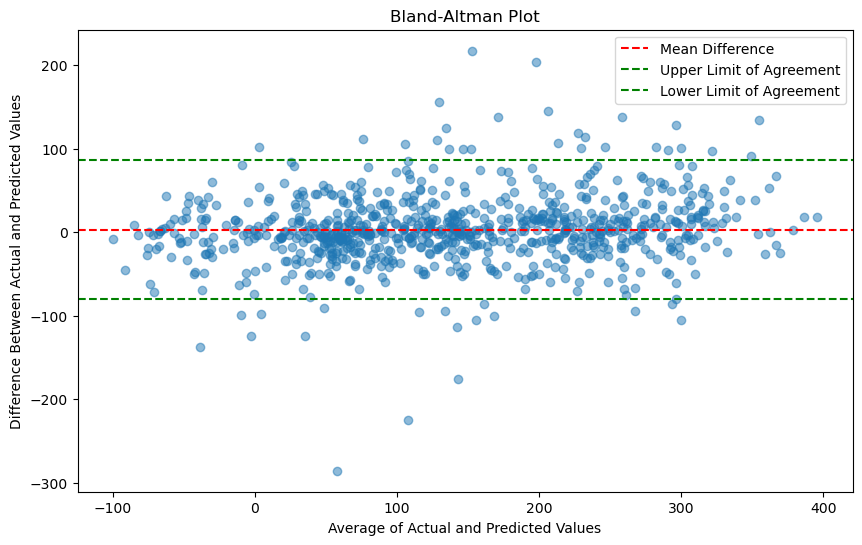

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Assuming 'df' is your DataFrame
# X should be your features, and y should be your target variable
cols = [c for c in new_df.columns if 'col' in c]
X = new_df[cols]
y = new_df['Glass transition temperature_value_median']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize the KNN Regressor model
model = KNeighborsRegressor(n_neighbors=5)  # 'n_neighbors' is the number of neighbors to consider, you can adjust it

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

evaluate_model_performance(y_test, y_pred)
plot_actual_vs_predicted(y_test, y_pred)
bland_altman_plot(y_test, y_pred)

In [9]:
def normalized_mse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    var_y = np.var(y_true)
    nmse = mse / var_y
    return nmse

def mean_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Avoid division by zero
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    
    # Calculate MPE
    mpe = abs(np.mean((y_true_non_zero - y_pred_non_zero) / y_true_non_zero) * 100)
    return mpe

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse


rmse_result = root_mean_squared_error(y_test, y_pred)
nmse_result = normalized_mse(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mpe_result = mean_percentage_error(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse_result}')
print(f'Mean Percentage Error: {mpe_result}')
print(f'Normalized Mean Squared Error: {nmse_result}')

Root Mean Squared Error: 42.39932393759872
Mean Percentage Error: 4.210077255865665
Normalized Mean Squared Error: 0.1435233292064352


## Decision Tree Regressor

The Decision Tree Regressor is a versatile machine learning algorithm that uses a decision tree structure to make predictions. It splits the data into subsets based on the value of input features, making the decision process hierarchical and resembling a tree structure. This method is popular for its simplicity, interpretability, and applicability to both numerical and categorical data. Below, I'll detail the pros and cons of using a Decision Tree Regressor, its applications, and its potential use in predicting glass transition temperatures from molecular fingerprints.

### Pros of Decision Tree Regressor

1. **Interpretability**: One of the primary advantages of decision trees is their ease of interpretation. They can be visualized, allowing for an intuitive understanding of how decisions are made.

2. **Handles Non-Linear Data**: Decision trees can model non-linear relationships without requiring transformations on the input variables.

3. **Automatic Feature Selection**: They inherently perform feature selection, prioritizing the most informative features at the top splits of the tree.

4. **No Need for Feature Scaling**: Decision trees do not require feature scaling (normalization or standardization) to be effective, as they are not sensitive to the variance in the data.

5. **Versatility**: Capable of handling both numerical and categorical data and can be used for both regression and classification tasks.

### Cons of Decision Tree Regressor

1. **Overfitting**: Without proper constraints (such as setting a maximum depth for the tree), decision trees can easily overfit the training data, capturing noise rather than the underlying pattern.

2. **Instability**: Small changes in the data can result in a completely different tree being generated. This instability can be somewhat mitigated by using ensemble methods like Random Forests or Gradient Boosting.

3. **Poor Performance on Unseen Data**: If the tree is too complex, it might perform poorly on unseen data due to overfitting.

4. **Simplicity Can Lead to Bias**: In trying to fit a model that simplifies the decision process, decision trees can introduce bias if the real-world data relationships are too complex for the tree structure to capture accurately.

### Applications

Decision Tree Regressors are widely used in various fields, including:

- **Real Estate**: For predicting property prices based on features such as location, size, and amenities.
- **Finance**: In credit scoring systems to evaluate the risk of lending to potential borrowers.
- **Energy Consumption**: Predicting the energy usage of buildings or appliances based on factors like time of day, occupancy, and weather conditions.
- **Environmental Science**: Estimating the carbon stock in forests based on satellite data and ground measurements.

### Predicting Glass Transition Temperatures from Molecular Fingerprints

Predicting glass transition temperatures from molecular fingerprints is a complex task that involves understanding how molecular structure influences physical properties. Decision Tree Regressor can be applied to this problem with several considerations:

- **Feature Representation**: Molecular fingerprints are typically high-dimensional binary vectors indicating the presence or absence of certain molecular features. Decision trees can handle this type of data, making them suitable for analyzing molecular fingerprints.

- **Complexity and Overfitting**: Given the complexity of the relationship between molecular structure and glass transition temperatures, care must be taken to avoid overfitting. Techniques such as pruning (limiting the depth of the tree) and cross-validation can be used to optimize model complexity.

- **Interpretability**: One of the benefits of using a Decision Tree Regressor for this application is the interpretability of the model. It can provide insights into which molecular features are most predictive of glass transition temperatures, which can be valuable for materials science research and development.

- **Integration with Ensemble Methods**: To improve prediction accuracy and stability, decision trees for this application can be integrated into ensemble methods like Random Forests or Gradient Boosted Trees, which can mitigate some of the decision tree's limitations like overfitting and instability.

In summary, while the Decision Tree Regressor has its limitations, its simplicity, interpretability, and the ability to handle complex, non-linear relationships make it a potentially valuable tool for predicting glass transition temperatures from molecular fingerprints. Proper model tuning and possibly leveraging ensemble methods could enhance its effectiveness for this application.

Mean Squared Error: 3857.215
R-squared: 0.692
Mean Absolute Error: 47.209
Explained Variance Score: 0.692
Median Absolute Error: 37.739


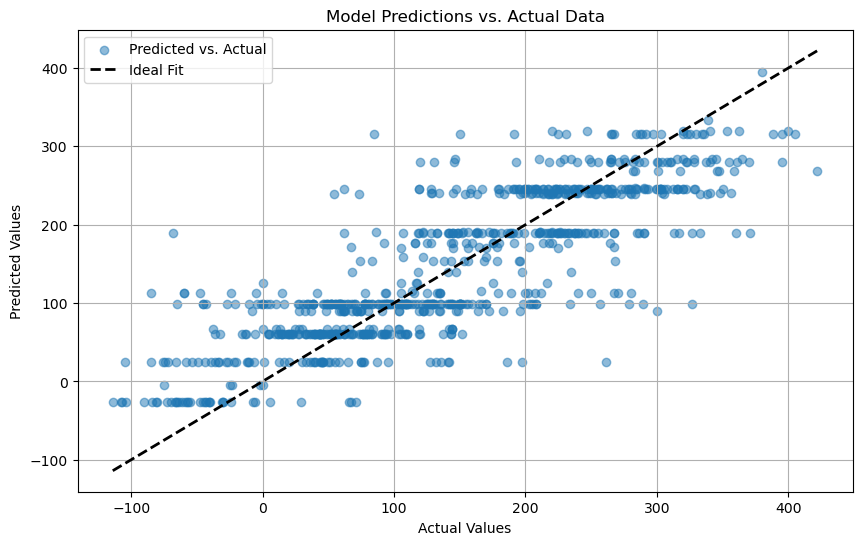

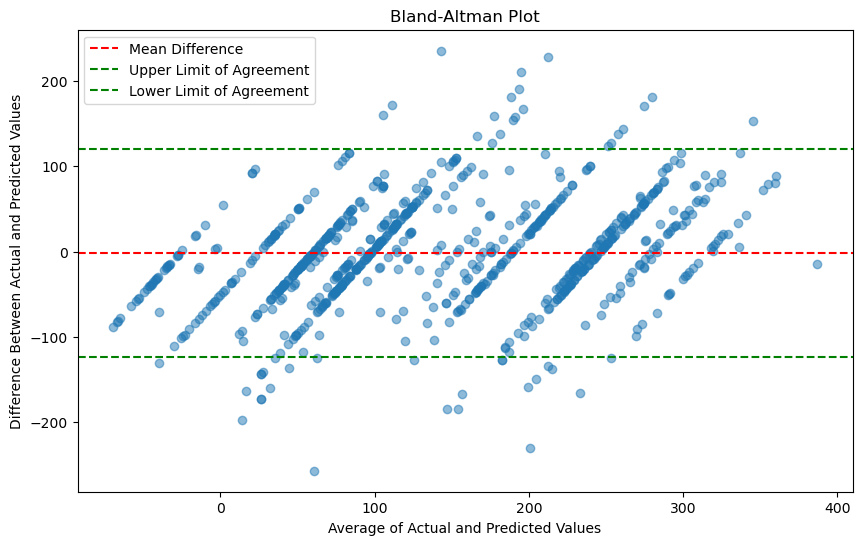

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Assuming 'df' is your DataFrame
# X should be your features, and y should be your target variable
cols = [c for c in new_df.columns if 'col' in c]
X = new_df[cols]
y = new_df['Glass transition temperature_value_median']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize the Decision Tree Regressor model
model = DecisionTreeRegressor(max_depth=5)  # 'max_depth' controls the maximum depth of the tree, you can adjust it

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

evaluate_model_performance(y_test, y_pred)
plot_actual_vs_predicted(y_test, y_pred)
bland_altman_plot(y_test, y_pred)

## Decision Tree & Bagging Regressor

Bagging (Bootstrap Aggregating) Regressor is an ensemble learning method that aims to improve the stability and accuracy of machine learning algorithms. It does so by combining the results of multiple base regressor models, each trained on a random subset of the original dataset (with replacement), to produce a more robust and accurate prediction. Bagging can be applied with various types of regressors as base models, but it is most commonly used with decision trees. Here, I'll discuss the pros and cons of Bagging Regressor, its applications, and its potential for predicting glass transition temperatures from molecular fingerprints.

### Pros of Bagging Regressor

1. **Reduces Overfitting**: By averaging the predictions of multiple models, bagging can reduce the chance of overfitting to the training data, improving the model's generalization to unseen data.

2. **Improves Stability and Accuracy**: The aggregation of predictions from multiple models tends to cancel out errors, leading to a more stable and accurate prediction than any single model.

3. **Handles High Variance Models Well**: Bagging is particularly effective with high variance, low bias models (like decision trees), as it helps in reducing variance without significantly increasing bias.

4. **Parallelizable**: Since each base model can be trained independently of the others, bagging is inherently parallelizable, which can speed up the training process.

5. **Versatility**: Bagging can be used with various types of regressors, making it a versatile approach that can be adapted to different kinds of prediction tasks.

### Cons of Bagging Regressor

1. **Increased Computational Cost**: Training multiple models requires more computational resources and time compared to training a single model.

2. **Model Complexity**: The final model can be more difficult to interpret than a single base model, as it consists of multiple underlying models' predictions.

3. **Memory Usage**: Storing multiple models in memory can be resource-intensive, especially with very large datasets or when using a large number of base estimators.

4. **Diminishing Returns**: Adding more base models to the ensemble leads to diminishing improvements in performance and, at some point, may not justify the additional computational cost.

### Applications

Bagging Regressors are widely used in various domains, such as:

- **Financial Sector**: For predicting stock prices, risk assessment, and credit scoring, where the model's accuracy and stability are crucial.
- **Environmental Modeling**: In forecasting weather patterns, temperature, and pollution levels, where predictions can be highly variable.
- **Healthcare**: For predicting disease outbreaks or patient prognosis, where aggregating predictions can improve reliability.
- **Real Estate**: In estimating property values, where diverse factors influence prices and a stable, accurate model is needed.

### Predicting Glass Transition Temperatures from Molecular Fingerprints

The task of predicting glass transition temperatures from molecular fingerprints involves understanding the complex relationships between molecular structures and their thermal properties. Bagging Regressor can be particularly useful for this application for several reasons:

- **Handling Complex Relationships**: The use of multiple models can help in capturing the complex, non-linear relationships between the molecular fingerprints (high-dimensional binary vectors indicating the presence or absence of specific molecular features) and the glass transition temperatures.

- **Reducing Overfitting**: Given the high dimensionality of the feature space, there's a risk of overfitting. Bagging helps in mitigating this risk by averaging out the noise across different models.

- **Improving Prediction Accuracy**: The ensemble approach of bagging can lead to more accurate predictions by reducing the variance of the model, which is particularly beneficial when predicting properties like glass transition temperatures that are sensitive to molecular structure.

For effective application, it's crucial to choose an appropriate base regressor that complements the bagging strategy and to tune the ensemble's parameters, such as the number of base estimators, to balance between computational cost and predictive performance. Combining bagging with decision trees or other suitable regressors could offer a powerful tool for accurately predicting glass transition temperatures, aiding in materials science research and development.

Mean Squared Error: 3426.558
R-squared: 0.726
Mean Absolute Error: 45.100
Explained Variance Score: 0.727
Median Absolute Error: 35.991


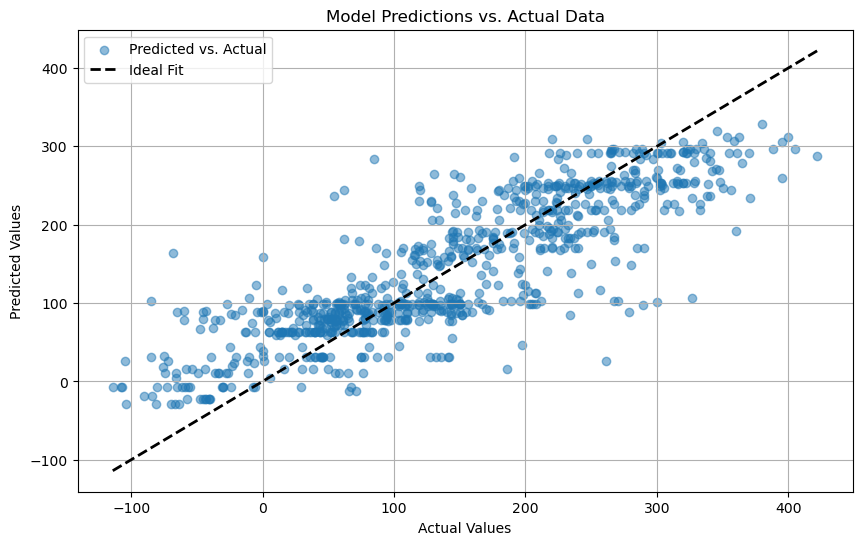

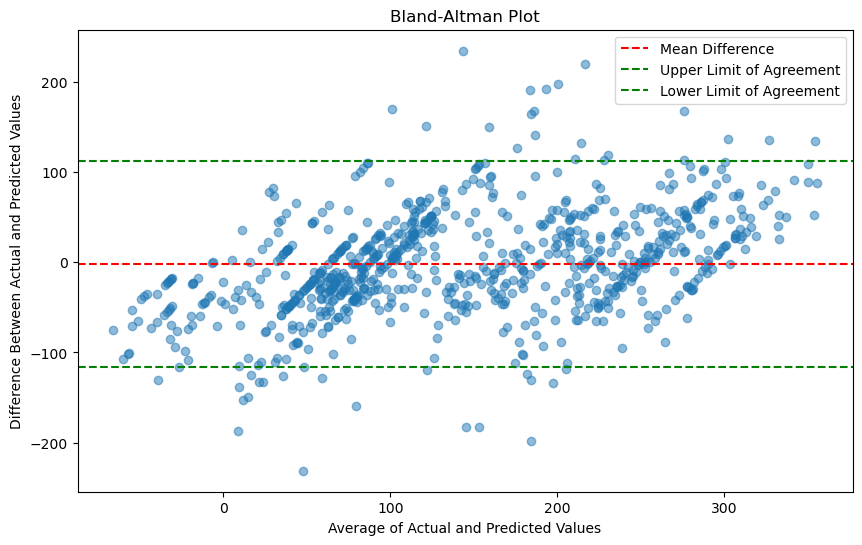

In [11]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'df' is your DataFrame
# X should be your features, and y should be your target variable
cols = [c for c in new_df.columns if 'col' in c]
X = new_df[cols]
y = new_df['Glass transition temperature_value_median']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize the base Decision Tree Regressor model
base_model = DecisionTreeRegressor(max_depth=5)  # You can adjust 'max_depth' based on your data

# Initialize the Bagging Regressor model
model = BaggingRegressor(base_model, n_estimators=10, random_state=42)
# 'n_estimators' is the number of base models (Decision Trees) in the ensemble, you can adjust it

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)


evaluate_model_performance(y_test, y_pred)
plot_actual_vs_predicted(y_test, y_pred)
bland_altman_plot(y_test, y_pred)

## Ada Boost and Decision Tree

The AdaBoostRegressor (Adaptive Boosting Regressor) is an ensemble machine learning algorithm that combines multiple weak learners (typically decision trees) to create a strong learner for regression tasks. It adapts by adjusting the weights of incorrectly predicted instances so that subsequent weak learners focus more on difficult cases. Here are the pros and cons of using AdaBoostRegressor, its applications, and its potential use in predicting glass transition temperatures from molecular fingerprints.

### Pros of AdaBoostRegressor

1. **Improved Accuracy**: By combining multiple weak models, AdaBoost can often achieve higher accuracy than individual models alone, especially if the weak learners are too simple or underfit the training data.

2. **Automatic Feature Selection**: AdaBoost can automatically select relevant features by giving more weight to the most informative features, which can improve model performance and reduce the dimensionality of the problem.

3. **Flexibility**: It can be used with any type of weak learner, although decision trees are the most common. This flexibility allows for customization based on the specific needs of the regression task.

4. **Ease of Use**: AdaBoost has fewer parameters to tune compared to some other machine learning algorithms, making it relatively easy to use and achieve good performance without extensive hyperparameter optimization.

### Cons of AdaBoostRegressor

1. **Sensitivity to Noisy Data and Outliers**: Because AdaBoost focuses on correcting mispredictions, it can be sensitive to noise and outliers in the data. This sensitivity can lead to overfitting to the noise, degrading the performance of the model on unseen data.

2. **Computationally Intensive**: Training can be computationally intensive, especially as the number of weak learners increases, because it is a sequential process where each model's performance affects the next.

3. **Risk of Overfitting**: Although generally more resistant to overfitting than some methods, in the presence of noisy data or when the weak learners are too complex, AdaBoost can still overfit.

### Applications

AdaBoostRegressor is widely applicable across many domains, including but not limited to:

- **Finance**: For predicting stock prices or market trends based on historical data.
- **Real Estate**: Estimating house prices based on features like location, size, and condition.
- **Energy**: Forecasting energy consumption or production levels based on factors such as weather conditions and demand.

### Predicting Glass Transition Temperatures from Molecular Fingerprints

When it comes to predicting glass transition temperatures from molecular fingerprints, AdaBoostRegressor has the potential to be a powerful tool, given its ability to handle complex non-linear relationships and automatically focus on challenging instances during the learning process. 

- **Handling High-Dimensional Data**: Molecular fingerprints are high-dimensional, and AdaBoost can effectively select the most informative features, reducing the dimensionality and potentially improving model performance.

- **Model Complexity and Overfitting**: Careful selection of the base estimator and tuning of the AdaBoost parameters (like the number of estimators and the learning rate) are crucial to avoid overfitting, especially given the complexity of the relationship between molecular structure and glass transition temperatures.

- **Interpretability**: While AdaBoost improves prediction accuracy, the ensemble nature of the model can make it more challenging to interpret than simpler models. However, examining the feature importance scores can still offer insights into which molecular features are most predictive of glass transition temperatures.

In summary, AdaBoostRegressor could be highly effective for predicting glass transition temperatures from molecular fingerprints, offering a balance between accuracy and ease of use. Its ability to focus on difficult-to-predict instances and automatically handle feature selection makes it particularly suited for complex regression tasks. However, careful consideration must be given to the choice of weak learners and the tuning of algorithm parameters to avoid overfitting, especially in the presence of noisy data or outliers.

Mean Squared Error: 3426.255
R-squared: 0.726
Mean Absolute Error: 45.472
Explained Variance Score: 0.727
Median Absolute Error: 37.887


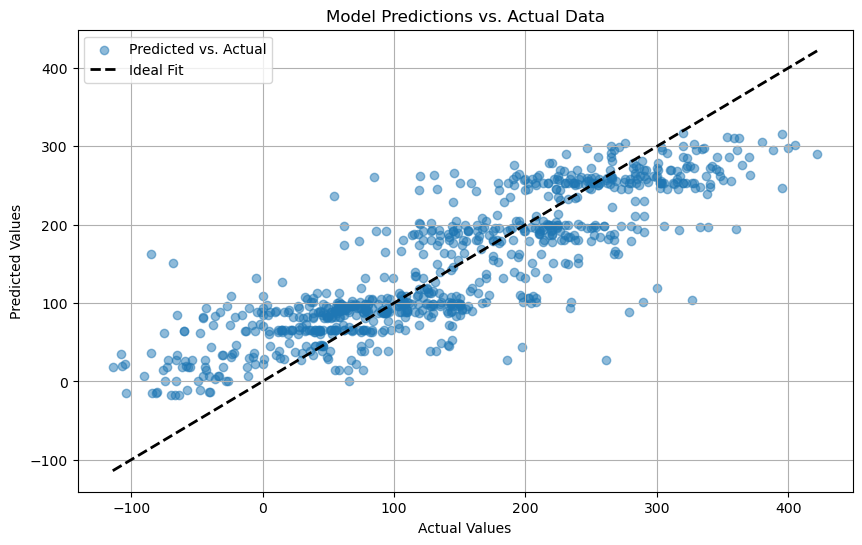

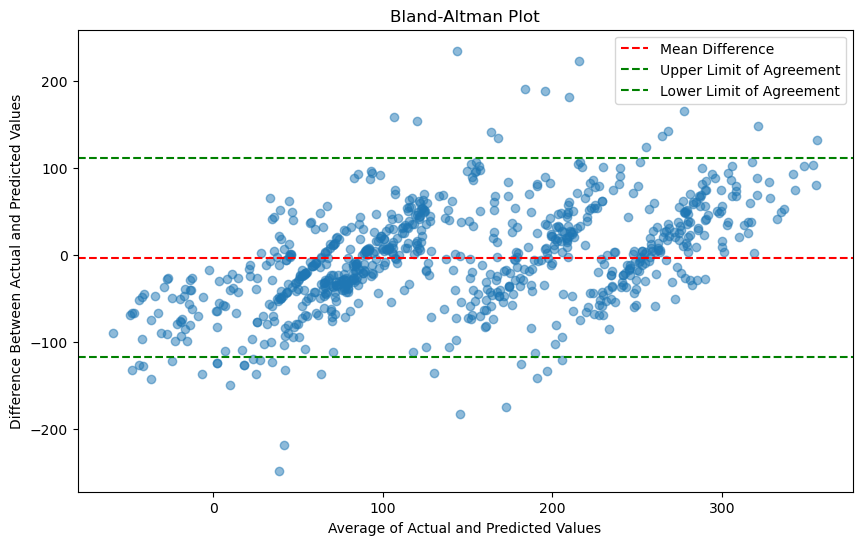

In [12]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Assuming 'df' is your DataFrame
# X should be your features, and y should be your target variable
cols = [c for c in new_df.columns if 'col' in c]
X = new_df[cols]
y = new_df['Glass transition temperature_value_median']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize the base Decision Tree Regressor model
base_model = DecisionTreeRegressor(max_depth=5)  # You can adjust 'max_depth' based on your data

# Initialize the AdaBoost Regressor model
model = AdaBoostRegressor(base_model, n_estimators=50, learning_rate=0.1, random_state=42)
# 'n_estimators' is the number of base models (Decision Trees) in the ensemble, and 'learning_rate' scales the contribution of each model

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)


evaluate_model_performance(y_test, y_pred)
plot_actual_vs_predicted(y_test, y_pred)
bland_altman_plot(y_test, y_pred)

## XGBoost

The XGBoost (Extreme Gradient Boosting) Regressor is an advanced implementation of gradient boosting algorithm that has gained popularity in machine learning for its performance and speed. XGBoost provides a highly efficient, flexible, and portable model. Here's an overview of its pros and cons, its applications, and its potential use in predicting glass transition temperatures from molecular fingerprints.

### Pros of XGBoost Regressor

1. **Performance and Speed**: XGBoost is designed for speed and performance. It is faster than most other implementations of gradient boosting due to its efficient use of system resources and optimization algorithms.

2. **Handling Sparse Data**: XGBoost can handle sparse data (like molecular fingerprints) directly, making it suitable for a wide range of datasets, including those typical in chemistry and biology.

3. **Regularization**: XGBoost includes L1 (Lasso) and L2 (Ridge) regularization, which helps in reducing overfitting and improving model performance on unseen data.

4. **Cross-validation**: Built-in cross-validation method at each iteration of the boosting process makes it easy to obtain accurate models while controlling for overfitting.

5. **Scalability**: XGBoost can handle large datasets and scale to distributed computing environments, making it suitable for problems requiring handling of large-scale data.

6. **Flexibility**: It supports custom optimization objectives and evaluation criteria, adding a layer of flexibility that allows for tailoring the model to specific needs.

### Cons of XGBoost Regressor

1. **Complexity**: While XGBoost offers many tuning parameters that can improve model performance, it can be challenging to fine-tune these parameters without overfitting or underfitting the model.

2. **Computationally Intensive**: For large datasets or complex models, XGBoost can be computationally intensive, requiring significant resources for training.

3. **Less Interpretability**: As with many ensemble methods, the complexity of the final model can make it less interpretable than simpler models, which can be a drawback in applications where understanding the model's decision-making process is important.

### Applications

XGBoost has been successfully applied in various domains, including but not limited to:

- **Finance**: Credit scoring, stock price prediction, and fraud detection.
- **Healthcare**: Predicting disease outbreaks, patient prognosis, and drug discovery.
- **Retail**: Customer behavior prediction, sales forecasting, and inventory management.
- **Energy**: Predicting energy demand and renewable energy output.

### Predicting Glass Transition Temperatures from Molecular Fingerprints

XGBoost Regressor is particularly well-suited for predicting glass transition temperatures from molecular fingerprints due to several of its features:

- **High-Dimensional Sparse Data**: XGBoost's ability to handle sparse data efficiently makes it ideal for working with molecular fingerprints, which are often represented as high-dimensional sparse vectors.

- **Complex Non-linear Relationships**: The algorithm's capability to model complex non-linear relationships allows it to capture the intricate dependencies between molecular structures and their physical properties, like glass transition temperatures.

- **Feature Importance**: XGBoost provides insights into feature importance, which can help in understanding how different molecular features influence the glass transition temperature.

- **Regularization**: The built-in regularization helps prevent overfitting, which is crucial given the complexity of the relationship between molecular features and glass transition temperatures.

To effectively use XGBoost for predicting glass transition temperatures, it is essential to carefully preprocess the molecular fingerprints, optimize the model's hyperparameters, and possibly incorporate domain knowledge into the model development process. With appropriate tuning and validation, XGBoost can be a powerful tool for this application, offering both high predictive performance and efficiency.

Mean Squared Error: 2638.422
R-squared: 0.789
Mean Absolute Error: 38.288
Explained Variance Score: 0.789
Median Absolute Error: 30.059


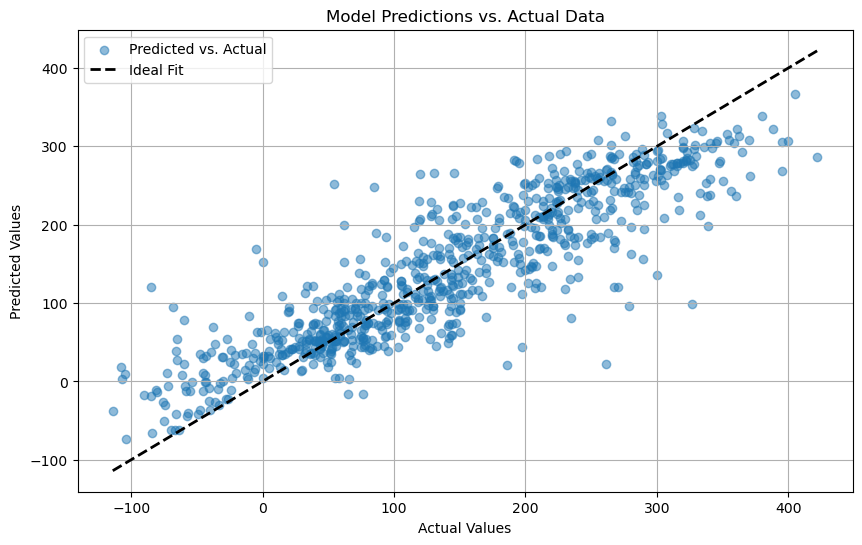

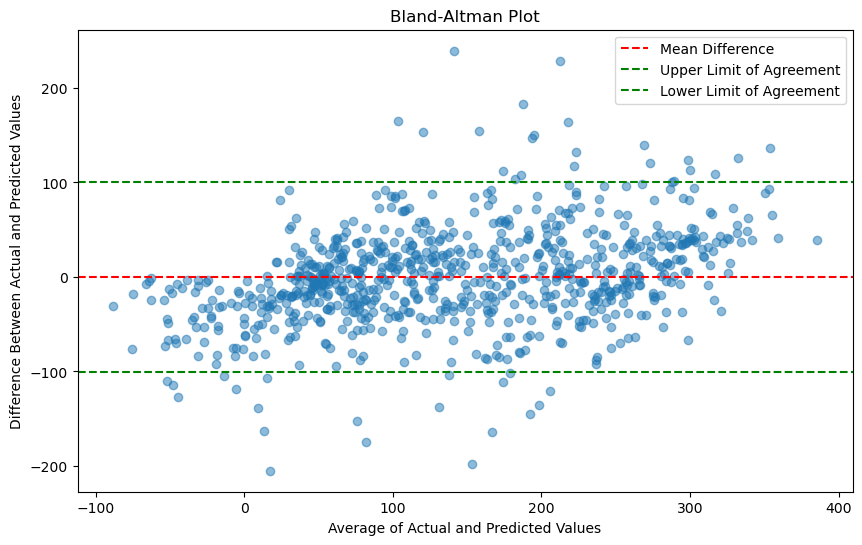

In [13]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Assuming 'df' is your DataFrame
# X should be your features, and y should be your target variable
cols = [c for c in new_df.columns if 'col' in c]
X = new_df[cols]
y = new_df['Glass transition temperature_value_median']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize the XGBoost Regressor model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
# 'n_estimators' is the number of boosting rounds, 'learning_rate' scales the contribution of each tree, and 'max_depth' controls the maximum depth of each tree

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

evaluate_model_performance(y_test, y_pred)
plot_actual_vs_predicted(y_test, y_pred)
bland_altman_plot(y_test, y_pred)

To evaluate and suggest the most suitable regressors for predicting glass transition temperatures from molecular fingerprints, let's summarize the pros and cons of each mentioned regressor and highlight their suitability for this specific application. The focus will be on their ability to handle high-dimensional data, capture non-linear relationships, and manage overfitting—all critical aspects when dealing with molecular fingerprints.

### Linear Regression
- **Pros**: Simple, interpretable.
- **Cons**: Struggles with non-linear relationships, high-dimensional data.
- **Suitability**: Not ideal for this task due to its inability to capture complex, non-linear relationships typically present in molecular data.

### RandomForestRegressor
- **Pros**: Handles non-linear data well, robust to overfitting.
- **Cons**: Can be slow with large datasets, less interpretable.
- **Suitability**: Good choice due to its ability to handle complexity and high dimensionality without severe overfitting.

### GradientBoostingRegressor
- **Pros**: High performance, handles non-linearity well, has good generalization.
- **Cons**: Can be sensitive to overfitting with noisy data, requires careful tuning.
- **Suitability**: A strong candidate given its performance but needs careful parameter tuning to prevent overfitting.

### Support Vector Regressor (SVR)
- **Pros**: Effective in high-dimensional spaces, versatile with kernel trick.
- **Cons**: Can be slow with large datasets, sensitive to hyperparameters.
- **Suitability**: Potentially useful, especially with the right kernel, but might be computationally intensive for large molecular datasets.

### Lasso Regression
- **Pros**: Performs feature selection, handles high-dimensionality well.
- **Cons**: May struggle with complex non-linear relationships.
- **Suitability**: Useful for dimensionality reduction but might not capture the full complexity of the data alone.

### ElasticNet
- **Pros**: Combines L1 and L2 regularization, good for high-dimensional data.
- **Cons**: Requires tuning of two parameters, may not handle non-linearity well.
- **Suitability**: Better than Lasso for this task due to its flexibility, but still may not fully capture complex relationships.

### KNeighborsRegressor
- **Pros**: Simple, intuitive, no assumptions about data.
- **Cons**: Suffers with high-dimensional data, computationally intensive.
- **Suitability**: Not recommended due to the curse of dimensionality and computational inefficiency with large, sparse data.

### DecisionTreeRegressor
- **Pros**: Capable of capturing non-linear relationships, interpretable.
- **Cons**: Prone to overfitting, not very robust on its own.
- **Suitability**: Not the best choice due to overfitting concerns; better used within an ensemble.

### BaggingRegressor
- **Pros**: Reduces variance, improves stability and accuracy.
- **Cons**: Can be slow, less interpretable due to ensemble nature.
- **Suitability**: A good option when combined with trees to handle the dataset's complexity and reduce overfitting.

### AdaBoostRegressor
- **Pros**: Focuses on difficult cases, improves weak learners.
- **Cons**: Sensitive to noisy data and outliers, can overfit.
- **Suitability**: Could be useful but requires careful tuning to avoid overfitting, especially with noisy data.

### XGBRegressor
- **Pros**: Fast, efficient, handles sparse data well, good for high-dimensional data.
- **Cons**: Can be complex to tune, less interpretable.
- **Suitability**: Excellent choice due to its performance, efficiency, and ability to handle sparse, high-dimensional data.

### Which to Pick?
- **Primary Choices**: **XGBRegressor**, **RandomForestRegressor**, and **GradientBoostingRegressor** stand out as the top choices due to their ability to handle high-dimensional data, capture complex relationships, and provide robust performance with appropriate tuning.
- **Secondary Choices**: **ElasticNet** and **Lasso Regression** could be considered for feature selection or as part of a hybrid model approach to reduce dimensionality before applying more complex models.

### Which to Avoid?
- **Linear Regression** and **KNeighborsRegressor** are less suitable due to their limitations in handling the complexity and high dimensionality of molecular fingerprints. **DecisionTreeRegressor** on its own is prone to overfitting and lacks the robustness required for this task.

### Conclusion
For predicting glass transition temperatures from molecular fingerprints, a combination of feature selection techniques (like ElasticNet) followed by a robust ensemble method (XGBRegressor, RandomForestRegressor, or GradientBoostingRegressor) could offer a powerful approach. These models balance the need for handling high-dimensional, complex data while minimizing the risk of overfitting. Careful tuning and validation are essential to achieving the best performance.